# Linear Regression / Regularized Linear Regression

Import libraries and load fixed data

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 

%matplotlib inline

In [31]:
train_o = pd.read_excel('train_fixed.xlsx', index_col='Id', keep_default_na = False)
test_o = pd.read_excel('test_fixed.xlsx', index_col='Id', keep_default_na = False)

In [33]:
train_o['MSSubClass'].dtype

dtype('int64')

## Data Exploration

### Multicollinearity

Multicollinearity results in coefficients with higher standard errors and causes the model to become unstable. Therefore, need to check for and resolve multicollinearity issues between features.

Plot correlation matrix and see if some highly correlated features can/should be removed.

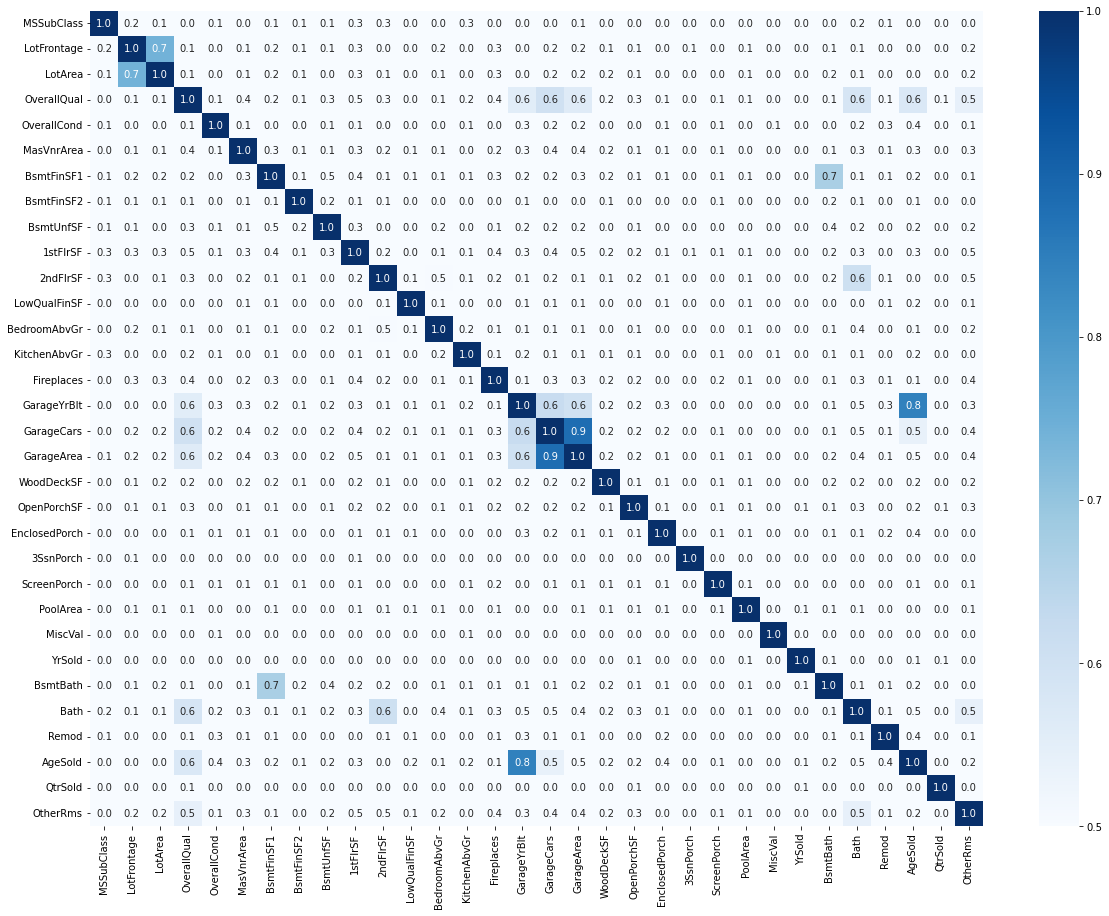

In [4]:
from pandas.plotting import scatter_matrix

corrMatrix = train_o.drop('SalePrice', axis = 1).corr().abs()

plt.figure(figsize=(20, 15))
sns.heatmap(corrMatrix, annot=True, vmin=0.5, fmt='.1f', cmap='Blues')

plt.show()

Make a table showing feature pairs that have correlation values > 0.7. Also make table showing correlation of each 

In [5]:
corr_df = pd.DataFrame(corrMatrix.unstack(), columns = ['Correlation'])
corr_df[(corr_df > 0.7) & (corr_df != 1)].dropna().drop_duplicates()

,,Correlation
LotFrontage,LotArea,0.740549
GarageYrBlt,AgeSold,0.844254
GarageCars,GarageArea,0.882475


In [6]:
target_corr = train_o.corr().abs()[['SalePrice']].sort_values('SalePrice', ascending = False)
target_corr

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GarageCars,0.640409
OtherRms,0.631425
GarageArea,0.623431
1stFlrSF,0.605852
Bath,0.597966
AgeSold,0.523350
GarageYrBlt,0.508043
MasVnrArea,0.472614


As shown, few feature pairs are highly correlated.

- LotFrontage & LotArea. This is expected, especially given that LotFrontage NA's were imputed with linear regression with LotArea as the independent variable. Will remove LotFrontage due to many NAs as well as LotArea logically being more important with higher correlation to target variable.


- GarageYrBlt & AgeSold. This is expected since for a vast majority of houses the year built will be the same. Will remove GarageYrBlt since AgeSold is logically more important with higher correlation to target variable.


- GarageCars & GarageArea. This is expected since garage size in car capacity is directly indicative of the garage area. Will remove GarageArea	since GarageCars has higher correlation to target variable.

In [7]:
train_m = train_o.drop(['LotFrontage', 'GarageYrBlt', 'GarageArea'], axis = 1)
test_m = test_o.drop(['LotFrontage', 'GarageYrBlt', 'GarageArea'], axis = 1)

### Normality

The assumption that residuals are normally distributed can be violated due to presence of outliers as well as non-normally distributed variables.

#### SalePrice

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

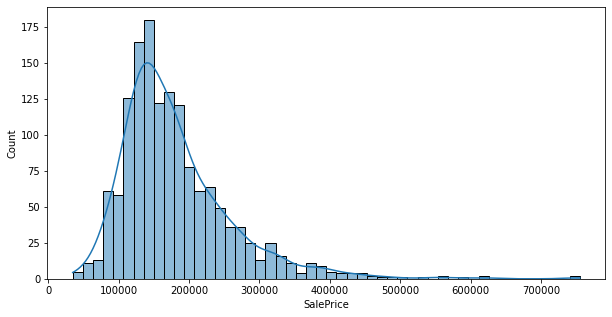

In [8]:
f, axes = plt.subplots(figsize=(10,5))
sns.histplot(train_m['SalePrice'], kde=True, bins=50)

SalesPrice is clearly skewed and not normally distributed. Apply log transformation.

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

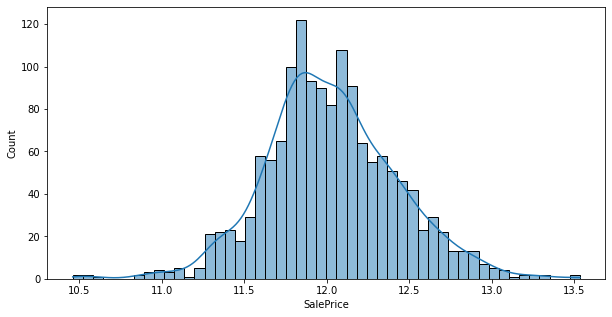

In [9]:
train_m['SalePrice'] = np.log(train_m['SalePrice'])

f, axes = plt.subplots(figsize=(10,5))
sns.histplot(train_m['SalePrice'], kde=True, bins=50)

#### 1stFlrSF

Features technically do not need to be normally distributed, but the residuals should be. Will check after running model if assumption is satisfied and transform features to be more normally distributed if necessary.

<AxesSubplot:xlabel='1stFlrSF', ylabel='Count'>

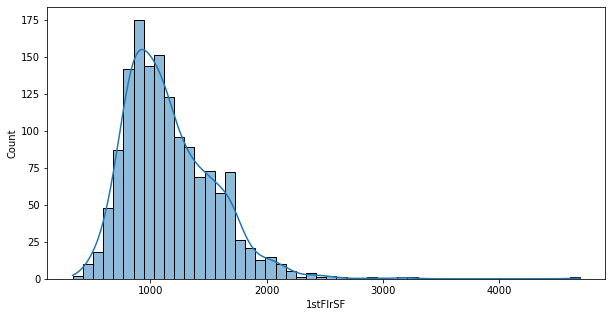

In [10]:
f, axes = plt.subplots(figsize=(10,5))
sns.histplot(train_m['1stFlrSF'], kde=True, bins=50)

In [11]:
# train_m['1stFlrSF'] = np.log(train_m['1stFlrSF'])

# f, axes = plt.subplots(figsize=(10,5))
# sns.histplot(train_m['1stFlrSF'], kde=True, bins=50)

#### Check for outliers

Check for outliers with the top 5 features with highest correlation to sale price.

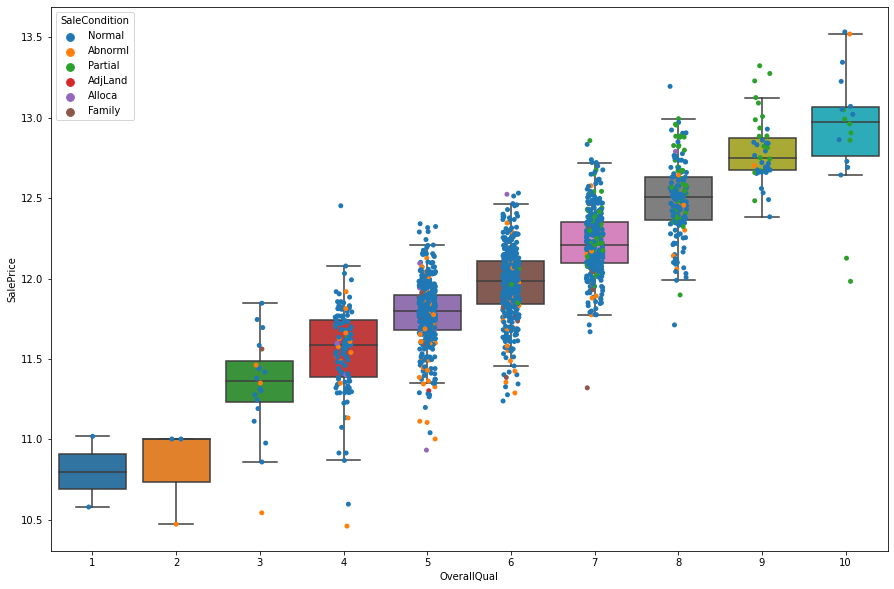

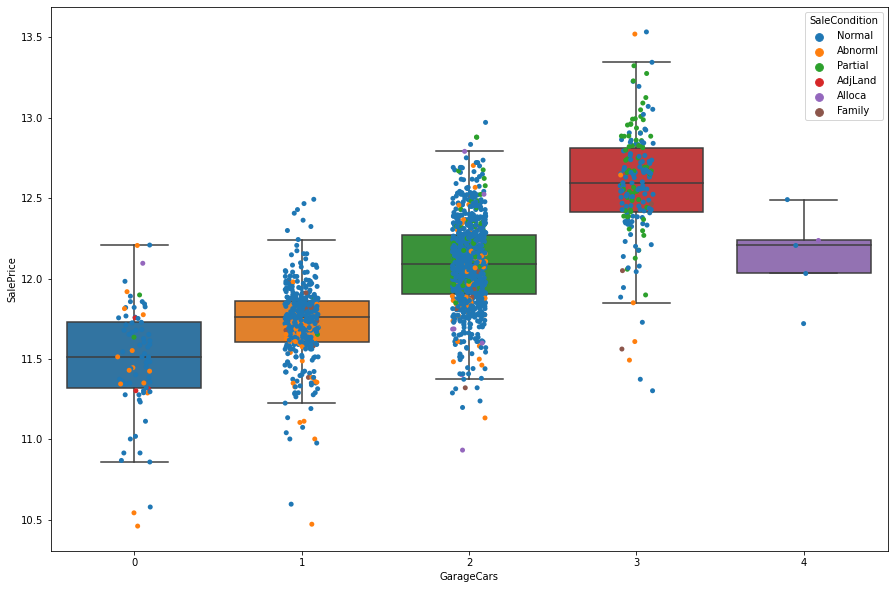

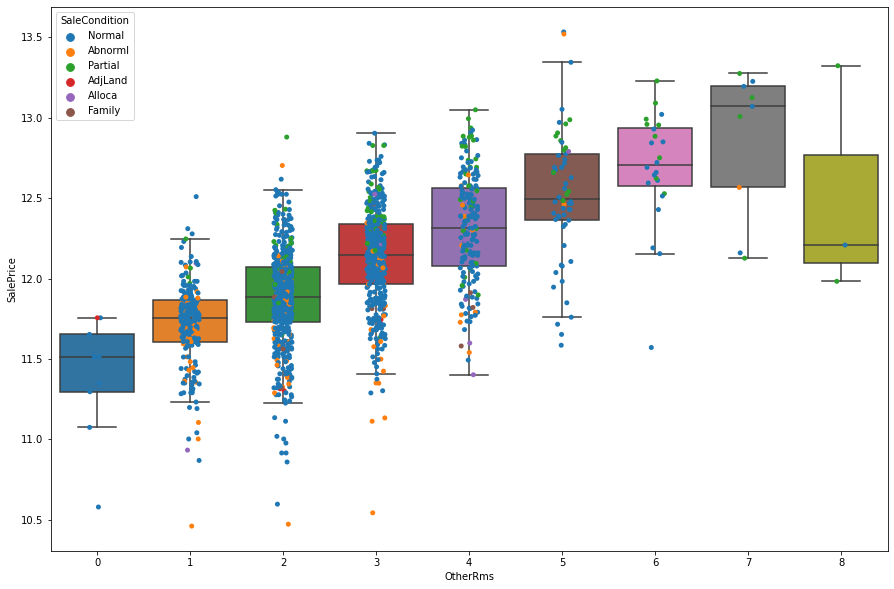

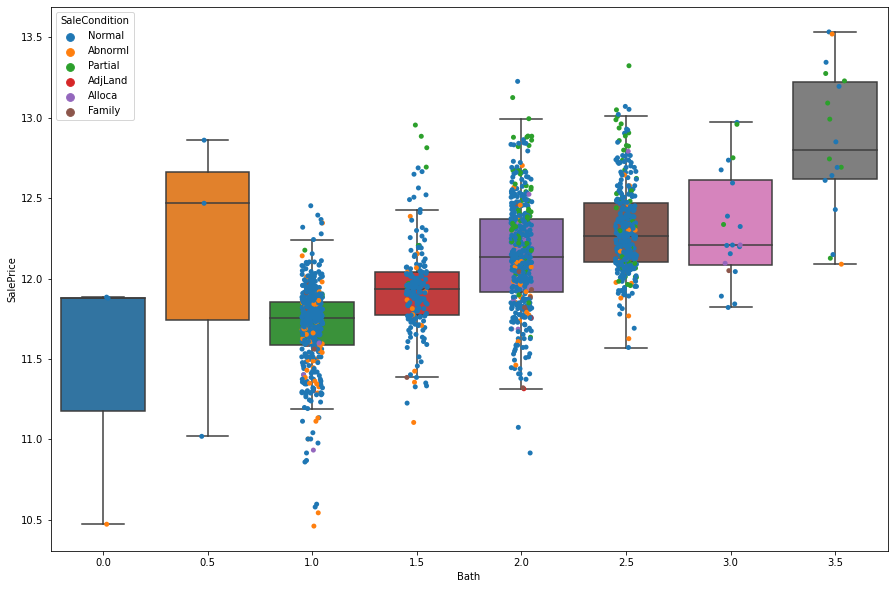

In [12]:
topordfeats = ['OverallQual', 'GarageCars', 'OtherRms', 'Bath']

for i, feat in enumerate(topordfeats):
    f, axes = plt.subplots(figsize=(15,10))
    sns.boxplot(y = 'SalePrice', x = feat, data = train_m, showfliers = False)
    sns.stripplot(y = 'SalePrice', x = feat, data = train_m, hue='SaleCondition')

As shown especially as a function of OverallQual, there are a few outliers that have non-normal SaleCondition that probably should be removed. Create a copy of data with outliers removed (original can be modeled for comparison). For each of the 4 top ordinal features, remove data points below 0.5 percentile and above 99.5 percentile.\
*Note: Doing so can remove enough points such that certain feature values don't have any entries, such as OverallQual of 1 or 2. Can implement method where if group has less than a certain count then do not remove outliers but will just go with this method for now.

In [13]:
def not_outlier(s):
    lower_limit = s.quantile(0.005)
    upper_limit = s.quantile(0.995)
    return s.between(lower_limit, upper_limit)

In [14]:
train_nooutlier = train_m.copy()
for feat in topordfeats:  
    train_nooutlier = train_nooutlier[train_nooutlier.groupby(feat)['SalePrice'].apply(not_outlier)]

In [15]:
# # Use this if do not want to remove outliers if data points in group is <3.

# for feat in topordfeats:
#     filtered_out = train_m.groupby(feat).filter(lambda x: x['SalePrice'].count() <= 3)
    
#     filtered = train_m.groupby(feat).filter(lambda x: x['SalePrice'].count() > 3)
#     train_nooutlier = filtered[filtered.groupby(feat)['SalePrice'].apply(not_outlier)]
#     train_m = pd.concat([train_nooutlier, filtered_out], axis = 0)

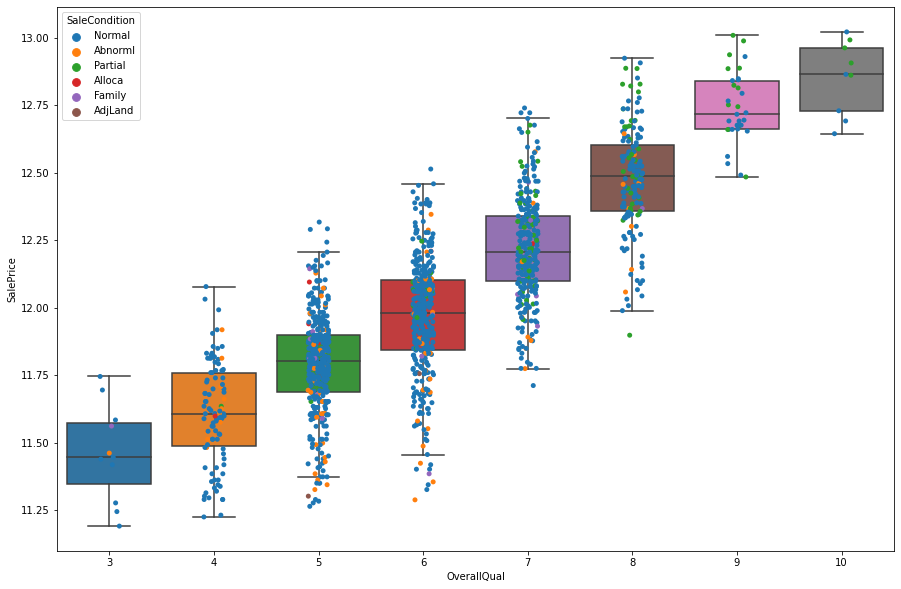

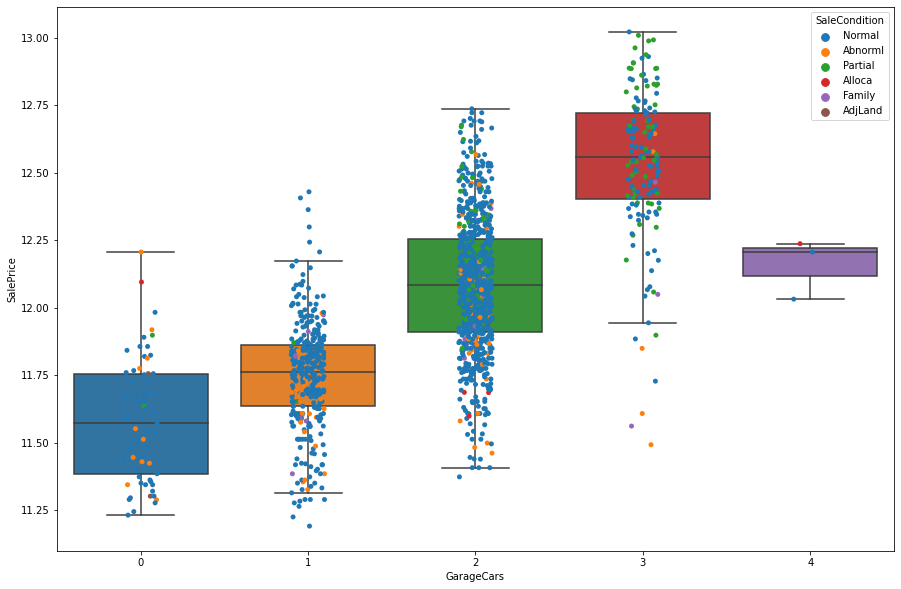

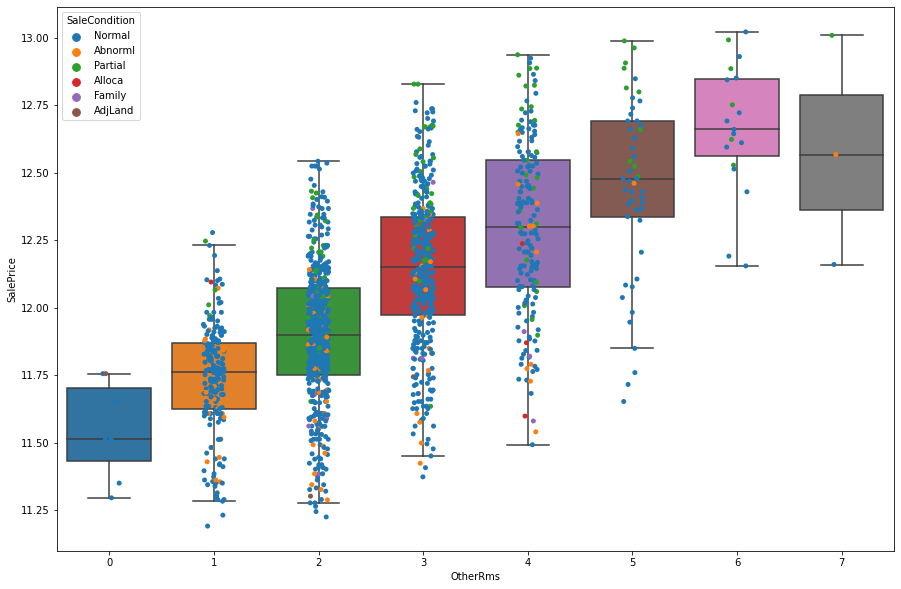

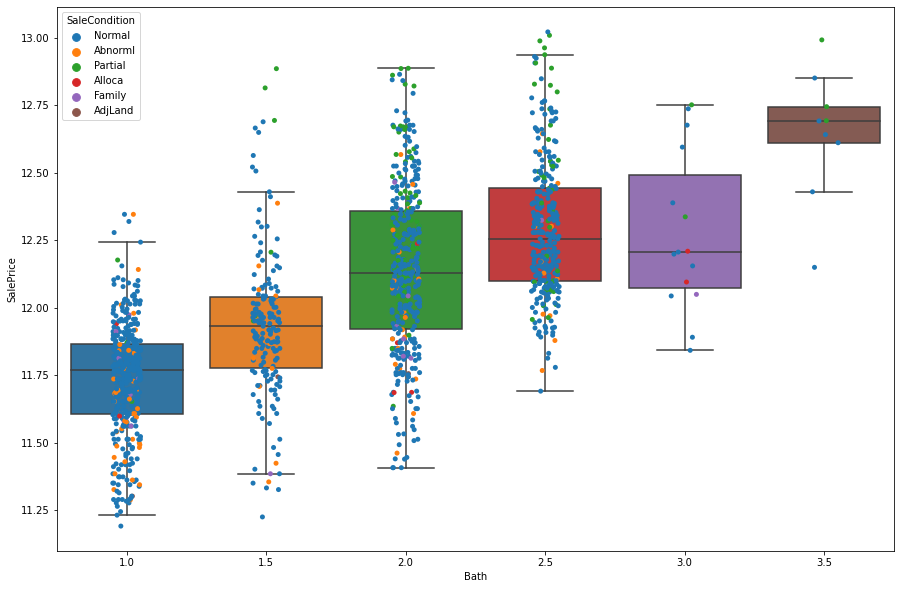

In [16]:
for i, feat in enumerate(topordfeats):
    f, axes = plt.subplots(figsize=(15,10))
    sns.boxplot(y = 'SalePrice', x = feat, data = train_nooutlier, showfliers = False)
    sns.stripplot(y = 'SalePrice', x = feat, data = train_nooutlier, hue='SaleCondition')

<AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice'>

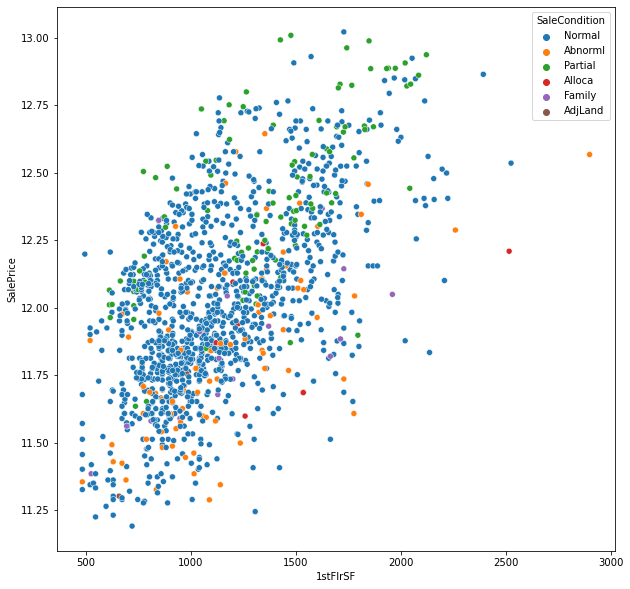

In [17]:
# 1stFlrSF
f, axes = plt.subplots(figsize=(10,10))
sns.scatterplot(y = 'SalePrice', x = '1stFlrSF', data = train_nooutlier, hue='SaleCondition')

Looks okay, will not remove any more data points.

## Encode Ordinal Features

In [18]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer

ord_fea = ['LotShape', 
           'Utilities', 
           'LandSlope', 
           'ExterQual', 
           'ExterCond', 
           'BsmtQual', 
           'BsmtCond', 
           'BsmtExposure', 
           'BsmtFinType1', 
           'BsmtFinType2', 
           'HeatingQC', 
           'KitchenQual', 
           'Functional', 
           'FireplaceQu', 
           'GarageFinish', 
           'GarageQual', 
           'GarageCond', 
           'PavedDrive', 
           'PoolQC', 
           'Fence']

ord_fea_cat = [None]*len(ord_fea)

ord_fea_cat[0] = ['IR3', 'IR2', 'IR1', 'Reg']
ord_fea_cat[1] = ['ELO', 'NoSeWa', 'NoSewr', 'AllPub']
ord_fea_cat[2] = ['Sev', 'Mod', 'Gtl']
ord_fea_cat[3] = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
ord_fea_cat[4] = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
ord_fea_cat[5] = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
ord_fea_cat[6] = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
ord_fea_cat[7] = ['NA', 'No', 'Mn', 'Av', 'Gd']
ord_fea_cat[8] = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
ord_fea_cat[9] = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
ord_fea_cat[10] = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
ord_fea_cat[11] = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
ord_fea_cat[12] = ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']
ord_fea_cat[13] = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
ord_fea_cat[14] = ['NA', 'Unf', 'RFn', 'Fin']
ord_fea_cat[15] = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
ord_fea_cat[16] = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
ord_fea_cat[17] = ['N', 'P', 'Y']
ord_fea_cat[18] = ['NA', 'Fa', 'TA', 'Gd', 'Ex']
ord_fea_cat[19] = ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']

ord_enc = OrdinalEncoder(categories=ord_fea_cat)

transformer = make_column_transformer((ord_enc, ord_fea))

transformed_train = transformer.fit_transform(train_m)
transformed_train_nooutlier = transformer.fit_transform(train_nooutlier)
transformed_test = transformer.fit_transform(test_m)

In [19]:
transformed_train_df = pd.DataFrame(transformed_train).set_index(train_m.index)
transformed_train_nooutlier_df = pd.DataFrame(transformed_train_nooutlier).set_index(train_nooutlier.index)
transformed_test_df = pd.DataFrame(transformed_test).set_index(test_m.index)

transformed_train_df.columns = ord_fea
transformed_train_nooutlier_df.columns = ord_fea
transformed_test_df.columns = ord_fea

In [20]:
train_mm = pd.concat([train_m.loc[:, ~train_m.columns.isin(ord_fea)], transformed_train_df], axis = 1)
train_nooutlier_mm = pd.concat([train_nooutlier.loc[:, ~train_nooutlier.columns.isin(ord_fea)], transformed_train_nooutlier_df], axis = 1)
test_mm = pd.concat([test_m.loc[:, ~test_m.columns.isin(ord_fea)], transformed_test_df], axis = 1)

## OneHotEncoder for Categorical Features

In [22]:
cat_feat = train_mm.select_dtypes(['object']).columns.tolist()

transformer = make_column_transformer((OneHotEncoder(drop='first'), cat_feat), remainder='passthrough')

transformed_train = transformer.fit_transform(train_mm)
transformed_train_df = pd.DataFrame(transformed_train, columns=transformer.get_feature_names_out())

transformed_train_nooutlier = transformer.fit_transform(train_nooutlier_mm)
transformed_train_nooutlier_df = pd.DataFrame(transformed_train_nooutlier, columns=transformer.get_feature_names_out())

transformed_test = transformer.fit_transform(test_mm)
transformed_test_df = pd.DataFrame(transformed_test, columns=transformer.get_feature_names_out())

## Train Model